#### By: Peyman Shahidi
#### Created: Nov 7, 2025
#### Last Edit: Nov 7, 2025

<br>

In [13]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [14]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/contiguityMeasure'
output_plot_path = f"{main_folder_path}/writeup/plots/contiguityMeasure"

In [15]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [16]:
def create_occupation_analysis(df, onet_occupation_code_var, onet_occupation_title_var):
    # Create occupation-level analysis for scatter plots
    # Group by occupation and calculate label fractions and task counts
    occupation_stats = []

    for (soc_code, occ_title), group in df.groupby([onet_occupation_code_var, onet_occupation_title_var]):
        num_tasks = group['Task ID'].nunique()
        # num_occupations = group[onet_occupation_code_var].nunique()
        total_tasks = len(group)
        
        manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
        augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
        automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
        ai_fraction = augmentation_fraction + automation_fraction
        gpt4_E0_fraction = (group['gpt4_exposure'] == 'E0').sum() / total_tasks
        gpt4_E1_fraction = (group['gpt4_exposure'] == 'E1').sum() / total_tasks
        gpt4_E2_fraction = (group['gpt4_exposure'] == 'E2').sum() / total_tasks
        gpt4_aiExposure_fraction = gpt4_E1_fraction + gpt4_E2_fraction
        human_E0_fraction = (group['human_labels'] == 'E0').sum() / total_tasks
        human_E1_fraction = (group['human_labels'] == 'E1').sum() / total_tasks
        human_E2_fraction = (group['human_labels'] == 'E2').sum() / total_tasks
        human_aiExposure_fraction = human_E1_fraction + human_E2_fraction

        
        occupation_stats.append({
            f'{onet_occupation_code_var}': soc_code,
            f'{onet_occupation_title_var}': occ_title,
            'num_tasks': num_tasks,
            # 'num_occupations': num_occupations,
            'manual_fraction': manual_fraction,
            'ai_fraction': ai_fraction,
            'augmentation_fraction': augmentation_fraction,
            'automation_fraction': automation_fraction,
            'gpt4_E0_fraction': gpt4_E0_fraction,
            'gpt4_E1_fraction': gpt4_E1_fraction,
            'gpt4_E2_fraction': gpt4_E2_fraction,
            'gpt4_aiExposure_fraction': gpt4_aiExposure_fraction,
            'human_E0_fraction': human_E0_fraction,
            'human_E1_fraction': human_E1_fraction,
            'human_E2_fraction': human_E2_fraction,
            'human_aiExposure_fraction': human_aiExposure_fraction
        })

    occupation_analysis = pd.DataFrame(occupation_stats)

    return occupation_analysis

In [17]:
# Read the merged data
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")

In [18]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

## Calculate Contiguity Measure defined as an indicator for whether +_ X tasks next to a task are AI Exposed (measured via E1 AI exposure measure)

In [19]:
# One-sided window length (number of steps to look left/right)
window_length = 2

In [20]:
# Calculate fragmentation index
# For the sake of this exercise we treat all AI tasks as a single category

# Create is_exposed column
cm_df = merged_data[['O*NET-SOC Code', 'Occupation Title', 'Task Position', 'Task ID', 'human_labels']].copy()
cm_df['human_labels'] = cm_df['human_labels'].fillna('E0')
cm_df['is_exposed'] = cm_df['human_labels'].isin(['E1']).astype(int)

# Ensure order within each occupation group (adjust if your ordering col is different)
group_cols = ['O*NET-SOC Code', 'Occupation Title']
order_cols = group_cols + (['Task Position'] if 'Task Position' in cm_df.columns else [])
cm_df = cm_df.sort_values(order_cols)

g = cm_df.groupby(group_cols, sort=False)

# --- Build all shifted exposure columns systematically ---
shifts = {}
for i in range(1, window_length + 1):
    shifts[f'previous_is_exposed_{i}'] = g['is_exposed'].shift(i).fillna(0).astype('int8')
    shifts[f'next_is_exposed_{i}']     = g['is_exposed'].shift(-i).fillna(0).astype('int8')

cm_df = cm_df.assign(**shifts)

# Helpers to reduce across an arbitrary list of Series
def max_reduce(series_list, default=0):
    if not series_list:
        return pd.Series(default, index=cm_df.index, dtype='int8')
    out = series_list[0].copy()
    for s in series_list[1:]:
        out = np.maximum(out, s)
    return out.astype('int8')

def min_reduce(series_list, default=1):
    if not series_list:
        return pd.Series(default, index=cm_df.index, dtype='int8')
    out = series_list[0].copy()
    for s in series_list[1:]:
        out = np.minimum(out, s)
    return out.astype('int8')

prev_cols = [cm_df[f'previous_is_exposed_{i}'] for i in range(1, window_length + 1)]
next_cols = [cm_df[f'next_is_exposed_{i}']     for i in range(1, window_length + 1)]

# 1) STRICT contiguity: entire block of size (2*W+1) is exposed
strict_block = min_reduce([cm_df['is_exposed']] + prev_cols + next_cols, default=1)
cm_df['is_contiguous_strict'] = strict_block  # 1 iff every neighbor within the window is exposed

# 2) ANY-ON-BOTH-SIDES contiguity: at least one exposed on the left AND one on the right (within window)
left_any  = max_reduce(prev_cols, default=0)
right_any = max_reduce(next_cols, default=0)
cm_df['is_contiguous_any_sides'] = (cm_df['is_exposed'].values & left_any.values & right_any.values).astype('int8')

# 3) Useful summaries: counts/shares in the window (incl. self)
neighbors_sum = sum(prev_cols + next_cols) if window_length > 0 else 0
cm_df['num_exposed_in_window']   = (neighbors_sum + cm_df['is_exposed']).astype('int16')
cm_df['share_exposed_in_window'] = cm_df['num_exposed_in_window'] / (2*window_length + 1)

# 4) Optional: length of the contiguous exposed block that includes the focal task
def exposed_block_len(s):
    grp = (s != s.shift()).cumsum()
    seg_size = s.groupby(grp).transform('size')
    return np.where(s.eq(1), seg_size, 0).astype('int16')

cm_df['exposed_block_len'] = g['is_exposed'].transform(exposed_block_len)

# A single flag choosing one of the options:
cm_df['is_contiguous'] = cm_df['is_contiguous_strict']

# Sort within groups by Task Position (ascending)
cm_df = cm_df.sort_values(['O*NET-SOC Code', 'Occupation Title', 'Task Position']).reset_index(drop=True)

# Index within group (0-based) and group sizes
g = cm_df.groupby(['O*NET-SOC Code', 'Occupation Title'], sort=False)
cm_df['_i'] = g.cumcount()
cm_df['_n'] = g['Task Position'].transform('size')

# Keep only interior rows: window_length ... n-1-window_length
keep = (cm_df['_i'] >= window_length) & (cm_df['_i'] < cm_df['_n'] - window_length)
cm_df = cm_df.loc[keep].drop(columns=['_i','_n']).reset_index(drop=True)

# Keep only relevant columns
cm_df = cm_df[['O*NET-SOC Code', 'Occupation Title', 'Task Position', 'Task ID', 'human_labels', 'share_exposed_in_window']]


# Create is_ai column
ai_df = merged_data[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'label']].copy()
ai_df['is_ai'] = ai_df['label'].isin(['Automation', 'Augmentation']).astype(int)

# Merge with cm_df 
cm_df = cm_df.merge(ai_df, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID'], how='left')

# Save contiguity measure data
cm_df.to_csv(f"{output_data_path}/contiguityMeasure.csv", index=False)
cm_df[cm_df['O*NET-SOC Code']=='15-1251.00']

,O*NET-SOC Code,Occupation Title,Task Position,Task ID,human_labels,share_exposed_in_window,label,is_ai
1749,15-1251.00,Computer Programmers,3,1276,E2,0.40,Automation,1
1750,15-1251.00,Computer Programmers,4,1273,E1,0.60,Augmentation,1
1751,15-1251.00,Computer Programmers,5,1270,E1,0.60,Automation,1
1752,15-1251.00,Computer Programmers,6,21049,E1,0.80,Manual,0
1753,15-1251.00,Computer Programmers,7,1269,E2,0.60,Augmentation,1
1754,15-1251.00,Computer Programmers,8,1268,E1,0.60,Manual,0
1755,15-1251.00,Computer Programmers,9,1275,E0,0.40,Augmentation,1
1756,15-1251.00,Computer Programmers,10,1267,E1,0.40,Automation,1
1757,15-1251.00,Computer Programmers,11,1272,E2,0.40,Automation,1
1758,15-1251.00,Computer Programmers,12,1278,E2,0.60,Augmentation,1


In [21]:
# Add back SOC levels for fixed effects in regressions
my_onet_level = 'detailed'
onet_occupation_code_var = 'Detailed_Occupation_Code'
onet_occupation_title_var = 'Detailed_Occupation_Title'

# Read OG occupation analysis with SOC mappings
ONET = pd.read_csv(f"{input_data_path}/computed_objects/ONET_cleaned_tasks.csv")

# Keep only the relevant 
SOC_mappings = ONET[['O*NET-SOC Code', 'Occupation Title',
                     'Major_Group_Code', 'Major_Group_Title',
                     'Minor_Group_Code', 'Minor_Group_Title',
                     'Broad_Occupation_Code', 'Broad_Occupation_Title',
                     'Detailed_Occupation_Code', 'Detailed_Occupation_Title']].copy()
SOC_mappings = SOC_mappings.drop_duplicates(subset=['O*NET-SOC Code', onet_occupation_code_var])

# Merge SOC levels with the occupation analysis
cm_df = cm_df.merge(SOC_mappings, on=['O*NET-SOC Code', 'Occupation Title'], how='left')

In [22]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Helper: compact table for selected vars
def coef_table(res, vars_):
    ci = res.conf_int().rename(columns={0: 'ci_low', 1: 'ci_high'})
    out = (pd.DataFrame({'coef': res.params, 'se': res.bse,
                         't': res.tvalues, 'p': res.pvalues})
           .join(ci)
           .loc[vars_])
    return out

vars_of_interest = ['share_exposed_in_window']

# --- Model A: no FE ---
mod_a = smf.logit(
    formula=f'is_ai ~ share_exposed_in_window',
    data=cm_df
).fit(cov_type="cluster",
    cov_kwds={
        "groups": cm_df['O*NET-SOC Code'],
        "use_correction": True,
        "df_correction": True
    })
print("\n\n=== Model A — selected coefficients ===")
print(coef_table(mod_a, vars_of_interest))


# For fixed effects, some major and minor groups have no variation in is_ai and thus lead to singular matrices
# Remove those from the analysis
def sanitize_for_fe_logit(df, fe, y, xcols, min_obs=3):
    d = df.dropna(subset=[fe, y] + xcols).copy()

    # 1) enough observations per FE
    cnt = d.groupby(fe).size()
    good = cnt[cnt >= min_obs].index
    d = d[d[fe].isin(good)]

    # 2) outcome must vary within FE (avoid complete separation by intercept)
    yvar = d.groupby(fe)[y].nunique()
    good = yvar[yvar > 1].index
    d = d[d[fe].isin(good)]

    # 3) regressors must vary within FE
    for x in xcols:
        xv = d.groupby(fe)[x].var()
        good = xv[xv > 0].index
        d = d[d[fe].isin(good)]

    return d

# —— Major FE ——
df_major = sanitize_for_fe_logit(cm_df, 'Major_Group_Code', 'is_ai', ['share_exposed_in_window'])

mod_b = smf.logit(
    'is_ai ~ share_exposed_in_window + C(Major_Group_Code)',
    data=df_major
).fit(method='lbfgs', maxiter=200, disp=0,
     cov_type='cluster',
     cov_kwds={'groups': df_major['Major_Group_Code'],
               'use_correction': True, 'df_correction': True})
print("\n\n=== Model B — selected coefficients ===")
print(coef_table(mod_b, vars_of_interest))

# —— Minor FE ——
df_minor = sanitize_for_fe_logit(cm_df, 'Minor_Group_Code', 'is_ai', ['share_exposed_in_window'])

# Try standard MLE first
mod_c = smf.logit(
        'is_ai ~ share_exposed_in_window + C(Minor_Group_Code)',
        data=df_minor
    ).fit(method='lbfgs', maxiter=300, disp=0,
         cov_type='cluster',
         cov_kwds={'groups': df_minor['Minor_Group_Code'],
                   'use_correction': True, 'df_correction': True})
print("\n\n=== Model C — selected coefficients ===")
print(coef_table(mod_c, vars_of_interest))


# Now run models A and B using the minor_df for sanity check:
mod_d = smf.logit(
        'is_ai ~ share_exposed_in_window',
        data=df_minor
    ).fit(method='lbfgs', maxiter=300, disp=0,
         cov_type='cluster',
         cov_kwds={'groups': df_minor['Minor_Group_Code'],
                   'use_correction': True, 'df_correction': True})
print("\n\n=== Model A with minor_df — selected coefficients ===")
print(coef_table(mod_d, vars_of_interest))

mod_e = smf.logit(
        'is_ai ~ share_exposed_in_window + C(Major_Group_Code)',
        data=df_minor
    ).fit(method='lbfgs', maxiter=300, disp=0,
         cov_type='cluster',
         cov_kwds={'groups': df_minor['Minor_Group_Code'],
                   'use_correction': True, 'df_correction': True})
print("\n\n=== Model B with minor_df — selected coefficients ===")
print(coef_table(mod_e, vars_of_interest))

Optimization terminated successfully.
         Current function value: 0.367549
         Iterations 6


=== Model A — selected coefficients ===
                         coef   se     t    p  ci_low  ci_high
share_exposed_in_window  2.54 0.15 17.09 0.00    2.25     2.83


=== Model B — selected coefficients ===
                         coef   se    t    p  ci_low  ci_high
share_exposed_in_window  0.98 0.17 5.67 0.00    0.64     1.32


=== Model C — selected coefficients ===
                         coef   se    t    p  ci_low  ci_high
share_exposed_in_window  0.76 0.19 4.06 0.00    0.39     1.13


=== Model A with minor_df — selected coefficients ===
                         coef   se    t    p  ci_low  ci_high
share_exposed_in_window  2.34 0.28 8.48 0.00    1.80     2.88


=== Model B with minor_df — selected coefficients ===
                         coef   se    t    p  ci_low  ci_high
share_exposed_in_window  0.98 0.20 4.94 0.00    0.59     1.37


In [23]:
# Batch-run regressions over many reshuffled datasets and save coefficients
import os
results = []

# Reuse the same contiguity calculation as above but as a function
def compute_cm_df(merged, window_length):
    cm_df = merged[['O*NET-SOC Code', 'Occupation Title', 'Task Position', 'Task ID', 'human_labels']].copy()
    cm_df['human_labels'] = cm_df['human_labels'].fillna('E0')
    cm_df['is_exposed'] = cm_df['human_labels'].isin(['E1']).astype(int)
    group_cols = ['O*NET-SOC Code', 'Occupation Title']
    order_cols = group_cols + (['Task Position'] if 'Task Position' in cm_df.columns else [])
    cm_df = cm_df.sort_values(order_cols)

    g = cm_df.groupby(group_cols, sort=False)
    shifts = {}
    for i in range(1, window_length + 1):
        shifts[f'previous_is_exposed_{i}'] = g['is_exposed'].shift(i).fillna(0).astype('int8')
        shifts[f'next_is_exposed_{i}']     = g['is_exposed'].shift(-i).fillna(0).astype('int8')
    cm_df = cm_df.assign(**shifts)

    def max_reduce(series_list, default=0):
        if not series_list:
            return pd.Series(default, index=cm_df.index, dtype='int8')
        out = series_list[0].copy()
        for s in series_list[1:]:
            out = np.maximum(out, s)
        return out.astype('int8')

    def min_reduce(series_list, default=1):
        if not series_list:
            return pd.Series(default, index=cm_df.index, dtype='int8')
        out = series_list[0].copy()
        for s in series_list[1:]:
            out = np.minimum(out, s)
        return out.astype('int8')

    prev_cols = [cm_df[f'previous_is_exposed_{i}'] for i in range(1, window_length + 1)]
    next_cols = [cm_df[f'next_is_exposed_{i}']     for i in range(1, window_length + 1)]

    strict_block = min_reduce([cm_df['is_exposed']] + prev_cols + next_cols, default=1)
    cm_df['is_contiguous_strict'] = strict_block
    left_any  = max_reduce(prev_cols, default=0)
    right_any = max_reduce(next_cols, default=0)
    cm_df['is_contiguous_any_sides'] = (cm_df['is_exposed'].values & left_any.values & right_any.values).astype('int8')

    neighbors_sum = sum(prev_cols + next_cols) if window_length > 0 else 0
    cm_df['num_exposed_in_window']   = (neighbors_sum + cm_df['is_exposed']).astype('int16')
    cm_df['share_exposed_in_window'] = cm_df['num_exposed_in_window'] / (2*window_length + 1)

    def exposed_block_len(s):
        grp = (s != s.shift()).cumsum()
        seg_size = s.groupby(grp).transform('size')
        return np.where(s.eq(1), seg_size, 0).astype('int16')

    cm_df['exposed_block_len'] = g['is_exposed'].transform(exposed_block_len)
    cm_df['is_contiguous'] = cm_df['is_contiguous_strict']

    cm_df = cm_df.sort_values(['O*NET-SOC Code', 'Occupation Title', 'Task Position']).reset_index(drop=True)
    g = cm_df.groupby(['O*NET-SOC Code', 'Occupation Title'], sort=False)
    cm_df['_i'] = g.cumcount()
    cm_df['_n'] = g['Task Position'].transform('size')
    keep = (cm_df['_i'] >= window_length) & (cm_df['_i'] < cm_df['_n'] - window_length)
    cm_df = cm_df.loc[keep].drop(columns=['_i','_n']).reset_index(drop=True)

    cm_df = cm_df[['O*NET-SOC Code', 'Occupation Title', 'Task Position', 'Task ID', 'human_labels', 'share_exposed_in_window']]
    ai_df = merged[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'label']].copy()
    ai_df['is_ai'] = ai_df['label'].isin(['Automation', 'Augmentation']).astype(int)
    cm_df = cm_df.merge(ai_df, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID'], how='left')
    if 'SOC_mappings' in globals():
        cm_df = cm_df.merge(SOC_mappings, on=['O*NET-SOC Code', 'Occupation Title'], how='left')
    return cm_df

# Fit models and extract coefficients (robust to errors)
def fit_models_and_extract(cm_df):
    out = {}
    # Model A: no FE (cluster by O*NET-SOC Code)
    try:
        m = smf.logit(formula='is_ai ~ share_exposed_in_window', data=cm_df).fit(
            disp=0,
            cov_type='cluster',
            cov_kwds={
                'groups': cm_df['O*NET-SOC Code'],
                'use_correction': True,
                'df_correction': True
            }
        )
        out['mod_a_coef'] = m.params.get('share_exposed_in_window', np.nan)
        out['mod_a_se'] = m.bse.get('share_exposed_in_window', np.nan)
        out['mod_a_p'] = m.pvalues.get('share_exposed_in_window', np.nan)
    except Exception as e:
        out['mod_a_error'] = str(e)
        out['mod_a_coef'] = np.nan; out['mod_a_se'] = np.nan; out['mod_a_p'] = np.nan

    # Model B: Major FE
    try:
        df_major = sanitize_for_fe_logit(cm_df, 'Major_Group_Code', 'is_ai', ['share_exposed_in_window'])
        m2 = smf.logit('is_ai ~ share_exposed_in_window + C(Major_Group_Code)', data=df_major).fit(
            method='lbfgs', maxiter=200, disp=0,
            cov_type='cluster',
            cov_kwds={'groups': df_major['Major_Group_Code'], 'use_correction': True, 'df_correction': True}
        )
        out['mod_b_coef'] = m2.params.get('share_exposed_in_window', np.nan)
        out['mod_b_se'] = m2.bse.get('share_exposed_in_window', np.nan)
        out['mod_b_p'] = m2.pvalues.get('share_exposed_in_window', np.nan)
    except Exception as e:
        out['mod_b_error'] = str(e)
        out['mod_b_coef'] = np.nan; out['mod_b_se'] = np.nan; out['mod_b_p'] = np.nan

    # Model C: Minor FE
    try:
        df_minor = sanitize_for_fe_logit(cm_df, 'Minor_Group_Code', 'is_ai', ['share_exposed_in_window'])
        m3 = smf.logit('is_ai ~ share_exposed_in_window + C(Minor_Group_Code)', data=df_minor).fit(
            method='lbfgs', maxiter=300, disp=0,
            cov_type='cluster',
            cov_kwds={'groups': df_minor['Minor_Group_Code'], 'use_correction': True, 'df_correction': True}
        )
        out['mod_c_coef'] = m3.params.get('share_exposed_in_window', np.nan)
        out['mod_c_se'] = m3.bse.get('share_exposed_in_window', np.nan)
        out['mod_c_p'] = m3.pvalues.get('share_exposed_in_window', np.nan)
    except Exception as e:
        out['mod_c_error'] = str(e)
        out['mod_c_coef'] = np.nan; out['mod_c_se'] = np.nan; out['mod_c_p'] = np.nan

    # Model D: no FE but on df_minor (sanity check)
    try:
        # ensure df_minor is available (recompute if previous failed)
        if 'df_minor' not in locals():
            df_minor = sanitize_for_fe_logit(cm_df, 'Minor_Group_Code', 'is_ai', ['share_exposed_in_window'])
        m4 = smf.logit('is_ai ~ share_exposed_in_window', data=df_minor).fit(
            method='lbfgs', maxiter=300, disp=0,
            cov_type='cluster',
            cov_kwds={'groups': df_minor['Minor_Group_Code'], 'use_correction': True, 'df_correction': True}
        )
        out['mod_d_coef'] = m4.params.get('share_exposed_in_window', np.nan)
        out['mod_d_se'] = m4.bse.get('share_exposed_in_window', np.nan)
        out['mod_d_p'] = m4.pvalues.get('share_exposed_in_window', np.nan)
    except Exception as e:
        out['mod_d_error'] = str(e)
        out['mod_d_coef'] = np.nan; out['mod_d_se'] = np.nan; out['mod_d_p'] = np.nan

    # Model E: Major FE but fitted on df_minor (as in earlier mod_e)
    try:
        if 'df_minor' not in locals():
            df_minor = sanitize_for_fe_logit(cm_df, 'Minor_Group_Code', 'is_ai', ['share_exposed_in_window'])
        m5 = smf.logit('is_ai ~ share_exposed_in_window + C(Major_Group_Code)', data=df_minor).fit(
            method='lbfgs', maxiter=300, disp=0,
            cov_type='cluster',
            cov_kwds={'groups': df_minor['Minor_Group_Code'], 'use_correction': True, 'df_correction': True}
        )
        out['mod_e_coef'] = m5.params.get('share_exposed_in_window', np.nan)
        out['mod_e_se'] = m5.bse.get('share_exposed_in_window', np.nan)
        out['mod_e_p'] = m5.pvalues.get('share_exposed_in_window', np.nan)
    except Exception as e:
        out['mod_e_error'] = str(e)
        out['mod_e_coef'] = np.nan; out['mod_e_se'] = np.nan; out['mod_e_p'] = np.nan

    return out

# 1) Add the observed/original dataset results (merged_data exists earlier in the notebook)
try:
    cm_obs = compute_cm_df(merged_data, window_length)
    row_obs = {'seed': 'observed'}
    row_obs.update(fit_models_and_extract(cm_obs))
    results.append(row_obs)
except Exception as e:
    print('Failed to compute observed dataset results:', e)

# 2) Loop over reshuffled files (attempt up to 1000) and collect results
n_rep = 1000
base_dir = f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/taskReshuffled_preserveCounts"
for seed in range(n_rep):
    if seed % 50 == 0:
        print(f'Iteration {seed+1} of {n_rep}')
    
    fpath = os.path.join(base_dir, f'ONET_Eloundou_Anthropic_GPT_iter{seed+1}.csv')
    if not os.path.exists(fpath):
        # Skip missing files (prints so user knows)
        if seed < 5:
            print(f'Missing {fpath} (skipping)')
        continue
    try:
        resh = pd.read_csv(fpath)
        cm = compute_cm_df(resh, window_length)
        row = {'seed': int(seed)}
        row.update(fit_models_and_extract(cm))
        results.append(row)
    except Exception as e:
        print(f'Failed seed {seed}: {e}')

# Save results to CSV for later plotting/comparison
res_df = pd.DataFrame(results)
out_file = f"{output_data_path}/reshuffle_regression_results_win{window_length}.csv"
res_df.to_csv(out_file, index=False)
print('Wrote regression results to', out_file)
res_df.head()

Iteration 1 of 1000
Iteration 51 of 1000
Iteration 101 of 1000
Iteration 151 of 1000
Iteration 201 of 1000
Iteration 251 of 1000
Iteration 301 of 1000
Iteration 351 of 1000
Iteration 401 of 1000
Iteration 451 of 1000
Iteration 501 of 1000
Iteration 551 of 1000
Iteration 601 of 1000
Iteration 651 of 1000
Iteration 701 of 1000
Iteration 751 of 1000
Iteration 801 of 1000
Iteration 851 of 1000
Iteration 901 of 1000
Iteration 951 of 1000
Wrote regression results to ../data/computed_objects/contiguityMeasure/reshuffle_regression_results_win2.csv


,seed,mod_a_coef,mod_a_se,mod_a_p,mod_b_coef,mod_b_se,mod_b_p,mod_c_coef,mod_c_se,mod_c_p,mod_d_coef,mod_d_se,mod_d_p,mod_e_coef,mod_e_se,mod_e_p
0,observed,2.54,0.15,0.00,0.98,0.17,0.00,0.76,0.19,0.00,2.34,0.28,0.00,0.98,0.20,0.00
1,0,2.63,0.16,0.00,0.95,0.15,0.00,0.74,0.14,0.00,2.48,0.32,0.00,0.97,0.17,0.00
2,1,2.74,0.17,0.00,1.12,0.21,0.00,0.90,0.19,0.00,2.62,0.33,0.00,1.14,0.21,0.00
3,2,2.65,0.15,0.00,0.95,0.15,0.00,0.76,0.17,0.00,2.49,0.31,0.00,0.97,0.19,0.00
4,3,2.70,0.16,0.00,1.05,0.12,0.00,0.83,0.17,0.00,2.51,0.31,0.00,1.05,0.18,0.00


Saved plot to ../writeup/plots/contiguityMeasure/hist_mod_a_coef_win2.png


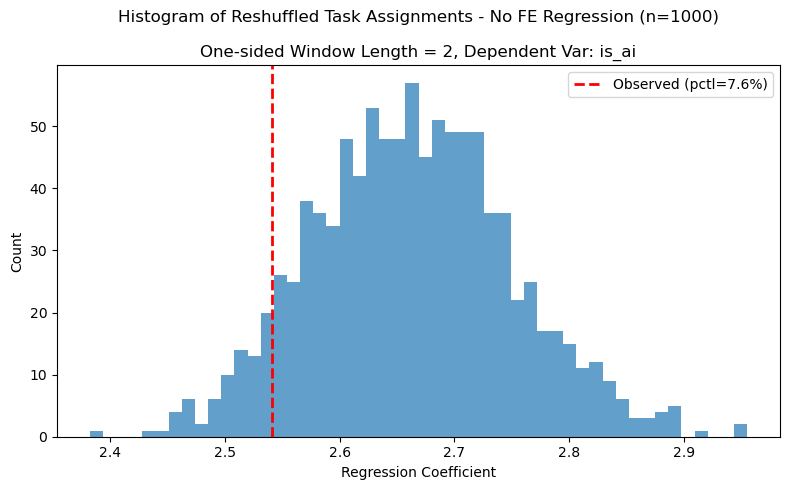

Saved plot to ../writeup/plots/contiguityMeasure/hist_mod_b_coef_win2.png


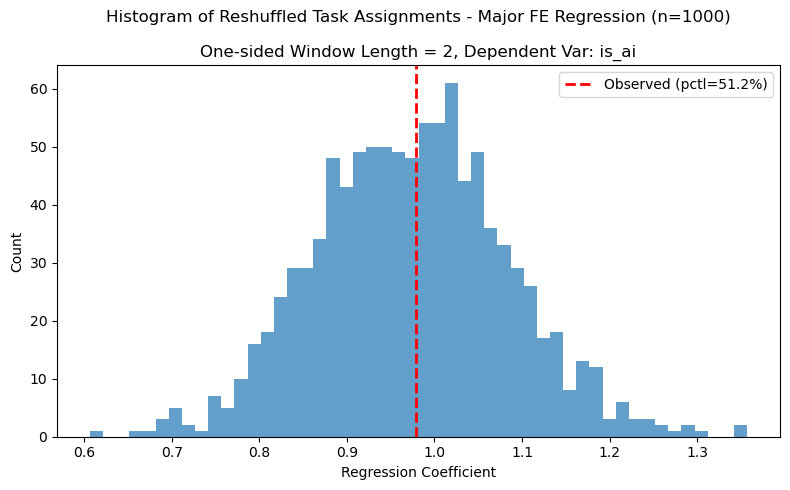

Saved plot to ../writeup/plots/contiguityMeasure/hist_mod_c_coef_win2.png


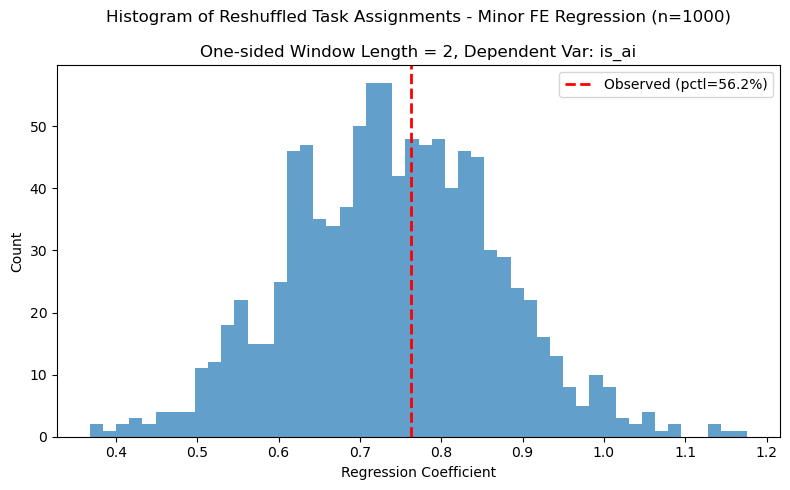

Saved plot to ../writeup/plots/contiguityMeasure/hist_mod_d_coef_win2.png


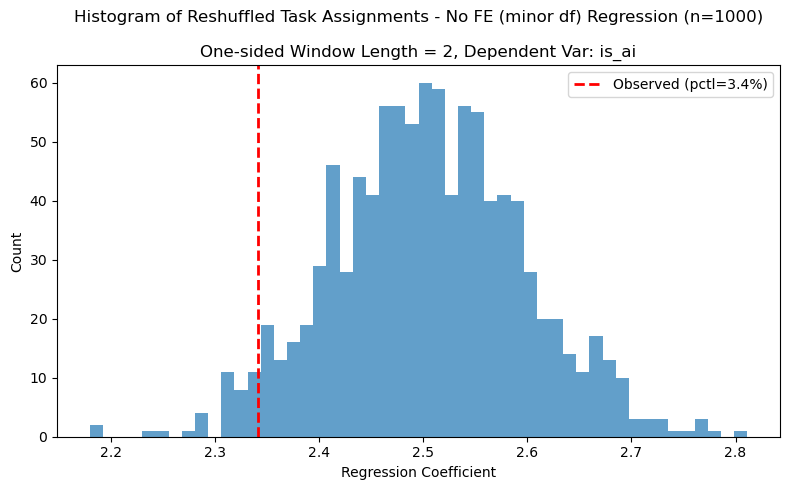

Saved plot to ../writeup/plots/contiguityMeasure/hist_mod_e_coef_win2.png


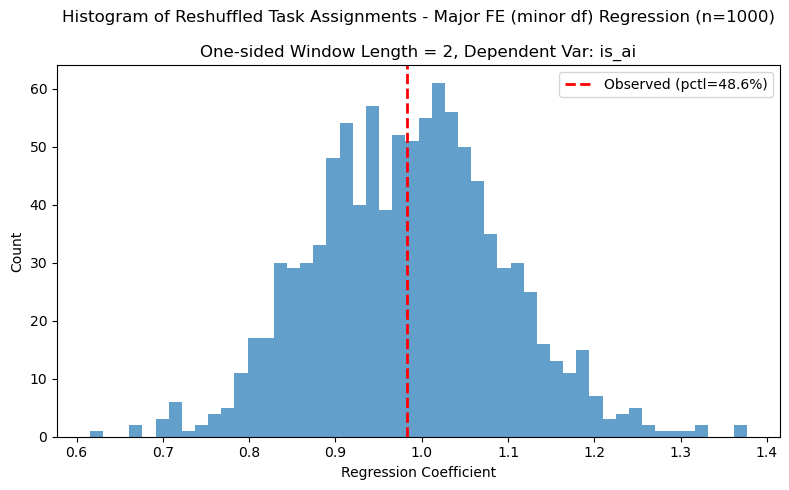

In [24]:
# Plot histogram of reshuffled coefficients and highlight observed value
import matplotlib.pyplot as plt

# Define models and their explanations
models = ['mod_a_coef', 'mod_b_coef', 'mod_c_coef', 'mod_d_coef', 'mod_e_coef']
model_explanation = ['No FE', 'Major FE', 'Minor FE', 'No FE (minor df)', 'Major FE (minor df)']

# Loop over models to create histograms
for model, explanation in zip(models, model_explanation):
    plot_df = pd.read_csv(f"{output_data_path}/reshuffle_regression_results_win{window_length}.csv")
    # Separate reshuffled (exclude 'observed')
    reshuffled = plot_df[plot_df['seed'] != 'observed'] if 'seed' in plot_df.columns else plot_df
    resh_vals = pd.to_numeric(reshuffled[model], errors='coerce').dropna()
    obs_row = plot_df[plot_df['seed'] == 'observed'] if 'seed' in plot_df.columns else pd.DataFrame()
    obs_val = float(obs_row[model].iloc[0])

    pct = (resh_vals <= obs_val).mean() * 100
    plt.figure(figsize=(8,5))
    plt.hist(resh_vals, bins=50, color='C0', alpha=0.7)
    plt.axvline(obs_val, color='red', linestyle='--', linewidth=2, label=f'Observed (pctl={pct:.1f}%)')
    plt.xlabel('Regression Coefficient')
    plt.ylabel('Count')
    plt.title(f'Histogram of Reshuffled Task Assignments - {explanation} Regression (n={len(resh_vals)})\n\nOne-sided Window Length = {window_length}, Dependent Var: is_ai')
    plt.legend()
    plt.tight_layout()
    # save plot to output_plot_path
    save_path = f"{output_plot_path}/hist_{model}_win{window_length}.png"
    plt.savefig(save_path, dpi=300)
    print('Saved plot to', save_path)
    plt.show()